In [188]:
# imports
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import networkx as nx


%matplotlib inline

In [ ]:
running_in_drive = True
if running_in_drive:
  import os
  os.chdir("/content/drive/MyDrive/GA/capstone/code")

# environment variables
DATA_PATH = '../data'
ORIGINAL_DATA_PATH = f'{DATA_PATH}/original/csv_offshore_leaks'
CLEAN_DATA_PATH = f'{DATA_PATH}/clean/csv_offshore_leaks'
NODE_EDGES_PATH = f'{DATA_PATH}/clean/csv_offshore_leaks/nodes_edges'
IMAGE_PATH = '../presentation/images'
MD_PATH = '../presentation/tables'

In [ ]:
# helpers


def get_clean_file_paths():
  file_names = os.listdir(CLEAN_DATA_PATH)
  return {f"{n.split('.')[0]}": f'{CLEAN_DATA_PATH}/{n}' for n in file_names if n.endswith('.csv')} 


def read_clean_dataframes():
  paths = get_clean_file_paths()
  data_frames = {}
  for name, path in paths.items():
    data_frames[name] = pd.read_csv(path)
  
  return data_frames



def print_number_of_rows(df):
  print(f'# rows: {df.shape[0]:,}')

In [ ]:
paths = get_clean_file_paths()
data_frames = read_clean_dataframes()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [229]:
ls ../data/clean/csv_offshore_leaks/nodes_edges

edges_all.csv  edges.csv  edges_info.csv  nodes.csv


In [230]:
nodes = pd.read_csv(f'{NODE_EDGES_PATH}/nodes.csv')
edges = pd.read_csv(f'{NODE_EDGES_PATH}/edges.csv')
edges_all = pd.read_csv(f'{NODE_EDGES_PATH}/edges_all.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,10,11,15,16,17,18,19,27,28,29,32,33,34,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [228]:
#edges_all = edges.merge(nodes, left_on='START_ID', right_on='node_id').merge(nodes, left_on='END_ID', right_on='node_id', suffixes=('_source', '_target')).drop_duplicates(subset=edges.columns)
#edges_all.to_csv(f'{NODE_EDGES_PATH}/edges_all.csv', index=False)

In [231]:
display(edges.head())
print_number_of_rows(edges)

,START_ID,END_ID,TYPE,link,start_date,end_date
0,67028,263908,registered_address,registered address,NaN,NaN
1,67243,172931,registered_address,registered address,NaN,NaN
2,67258,264788,registered_address,registered address,NaN,NaN
3,67266,263908,registered_address,registered address,NaN,NaN
4,108050,285718,registered_address,registered address,NaN,NaN


# rows: 561,393


In [232]:
display(edges_all.head(2))
print_number_of_rows(edges_all)

,START_ID,END_ID,TYPE,link,start_date,end_date,node_id_source,country_codes_source,countries_source,continents_source,status_source,jurisdiction_source,name_source,address_source,table_source,jurisdiction_description_source,incorporation_date_source,ibcRUC_source,company_type_source,service_provider_source,state_source,latitude_source,longitude_source,node_id_target,country_codes_target,countries_target,continents_target,status_target,jurisdiction_target,name_target,address_target,table_target,jurisdiction_description_target,incorporation_date_target,ibcRUC_target,company_type_target,service_provider_target,state_target,latitude_target,longitude_target
0,67028,263908,registered_address,registered address,NaN,NaN,67028,VGB;CYP,British Virgin Islands;Cyprus,North America;Asia,Dead,XXX,ZODIAK LTD,NaN,entity,Undetermined,24-AUG-2007,1427813,Business Company Limited by Shares,Commonwealth Trust Limited,NaN,NaN,NaN,263908,CYP,Cyprus,Asia,NaN,NaN,NaN,Christabel Corporate Services Limited Christab...,address,NaN,NaN,NaN,NaN,NaN,NaN,34.982302,33.145128
1,67266,263908,registered_address,registered address,NaN,NaN,67266,CYP;VGB,Cyprus;British Virgin Islands,Asia;North America,Transferred OUT,XXX,GIADA LTD,NaN,entity,Undetermined,14-JUN-2007,1411204,Business Company Limited by Shares,Commonwealth Trust Limited,NaN,NaN,NaN,263908,CYP,Cyprus,Asia,NaN,NaN,NaN,Christabel Corporate Services Limited Christab...,address,NaN,NaN,NaN,NaN,NaN,NaN,34.982302,33.145128


# rows: 561,390


In [392]:
def draw_graphs(G, title, thresh=0):
  fig, axs = plt.subplots(2, 3, figsize=(6*3, 6*2))
  prop = {'node_size': 1200, 'node_shape':'o', 'cmap': 'seismic', 'alpha': .5}
  nx.draw_networkx(G,with_labels=True, **prop, ax=axs[0, 0]) 
  axs[0,0].set_title('draw_neworkx')
  axs[0,0].set_axis_off()

  nx.draw(G,with_labels=True, **prop, ax=axs[0, 1])  
  axs[0,1].set_title('draw')
  axs[0,1].set_axis_off()

  nx.draw_random(G,with_labels=True, **prop, ax=axs[0, 2])  
  axs[0,2].set_title('random')
  axs[0,2].set_axis_off()

  nx.draw_circular(G,with_labels=True, **prop, ax=axs[1, 0])  
  axs[1,0].set_title('circular')
  axs[1,0].set_axis_off()

  nx.draw_spectral(G,with_labels=True, **prop, ax=axs[1, 1]) 
  axs[1,1].set_title('spectral')
  axs[1,1].set_axis_off()

  nx.draw_spring(G,with_labels=True, **prop, ax=axs[1, 2])
  axs[1,2].set_title('spring')
  axs[1,2].set_axis_off()
  title_text = title.replace('_', ' ').title()
  plt.suptitle(title_text, fontsize=20)

  plt.savefig(f'{IMAGE_PATH}/graphs_{title}_thresh_{thresh}.png', dpi=300, bbox_inches='tight')
  # plt.title('draw_neworkx')
  # plt.axis('off')

In [403]:
def create_weight_df(data_frame, field, make_graph=False, figsize=(6, 6), thresh=0, select_thresh=False):
  source = f'{field}_source'
  target = f'{field}_target'
  out = {}
  print_number_of_rows(data_frame)
  df = data_frame[[source, target]]
  df['weight'] = 0
  df = df.groupby([source, target]).count()
  df.reset_index(inplace=True)
  print_number_of_rows(df)
  if type(df[source][0])==str:
    df = df[(df[source].str.split(';').str.len()==1) & (df[target].str.split(';').str.len()==1)]
    print_number_of_rows(df)
  if select_thresh:
    thresh = int(df['weight'].max()/1000) or 10
  df = df[df['weight']>thresh]
  display(df.sort_values(by='weight', ascending=False).head())
  out.update({'df': df})
  if make_graph: 
    G = nx.from_pandas_edgelist(df, source=source, target=target, 
                                edge_attr='weight', 
                                create_using=nx.DiGraph())
    
    draw_graphs(G, field, thresh)

  out.update({'source': source, 'target': target})
  return out

In [404]:
out = {}

out.update({'node_id': create_weight_df(edges_all, 'node_id')})

# rows: 561,390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# rows: 504,670


,node_id_source,node_id_target,weight
297501,117787,167780,6
294053,116729,169478,6
96852,49496,172779,5
242714,93375,167475,5
73943,43439,167443,5


In [405]:
pd.DataFrame(edges_all.loc[edges_all['country_codes_target']=='XXX', 'country_codes_source'].value_counts())

,country_codes_source
HKG,5077
USA,3823
XXX,3677
SGP,1447
TWN,1441
...,...
MDA,1
COL,1
IDN;HKG;AUS,1
GRD,1


In [406]:
edges_all.loc[(edges_all['country_codes_target']=='XXX') & (edges_all['country_codes_source']=='XXX')].shape

(3677, 40)

In [407]:
edges_all.head(2)

,START_ID,END_ID,TYPE,link,start_date,end_date,node_id_source,country_codes_source,countries_source,continents_source,status_source,jurisdiction_source,name_source,address_source,table_source,jurisdiction_description_source,incorporation_date_source,ibcRUC_source,company_type_source,service_provider_source,state_source,latitude_source,longitude_source,node_id_target,country_codes_target,countries_target,continents_target,status_target,jurisdiction_target,name_target,address_target,table_target,jurisdiction_description_target,incorporation_date_target,ibcRUC_target,company_type_target,service_provider_target,state_target,latitude_target,longitude_target
0,67028,263908,registered_address,registered address,NaN,NaN,67028,VGB;CYP,British Virgin Islands;Cyprus,North America;Asia,Dead,XXX,ZODIAK LTD,NaN,entity,Undetermined,24-AUG-2007,1427813,Business Company Limited by Shares,Commonwealth Trust Limited,NaN,NaN,NaN,263908,CYP,Cyprus,Asia,NaN,NaN,NaN,Christabel Corporate Services Limited Christab...,address,NaN,NaN,NaN,NaN,NaN,NaN,34.982302,33.145128
1,67266,263908,registered_address,registered address,NaN,NaN,67266,CYP;VGB,Cyprus;British Virgin Islands,Asia;North America,Transferred OUT,XXX,GIADA LTD,NaN,entity,Undetermined,14-JUN-2007,1411204,Business Company Limited by Shares,Commonwealth Trust Limited,NaN,NaN,NaN,263908,CYP,Cyprus,Asia,NaN,NaN,NaN,Christabel Corporate Services Limited Christab...,address,NaN,NaN,NaN,NaN,NaN,NaN,34.982302,33.145128


# rows: 561,390
# rows: 29
# rows: 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,jurisdiction_source,jurisdiction_target,weight
9,COOK,COOK,201
1,BVI,BVI,156
7,CAYMN,XXX,84
27,XXX,CAYMN,84


# rows: 561,390
# rows: 4,393
# rows: 910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,countries_source,countries_target,weight
370,British Virgin Islands,British Virgin Islands,49298
1366,Hong Kong,British Virgin Islands,47319
2483,Not identified,British Virgin Islands,28180
3730,Taiwan,Taiwan,16791
1396,Hong Kong,Hong Kong,16450


# rows: 561,390
# rows: 4,393
# rows: 910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,country_codes_source,country_codes_target,weight
3521,VGB,VGB,49298
1346,HKG,VGB,47319
4121,XXX,VGB,28180
3218,TWN,TWN,16791
1311,HKG,HKG,16450


# rows: 561,390
# rows: 618
# rows: 40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,continents_source,continents_target,weight
46,Asia,North America,104477
361,North America,North America,63848
34,Asia,Asia,63486
559,XXX,North America,28773
57,Asia,Oceania,19554


# rows: 561,390
# rows: 37
# rows: 37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,company_type_source,company_type_target,weight
36,Standard International Company,Standard International Company,94
30,Standard International Company,BVI Trust,76
2,BVI Trust,Standard International Company,75
21,Mutual Fund,Mutual Fund,52
25,Mutual Fund Manager,Mutual Fund Manager,48


# rows: 561,390
# rows: 29
# rows: 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,jurisdiction_description_source,jurisdiction_description_target,weight
9,Cook Islands,Cook Islands,201
1,British Virgin Islands,British Virgin Islands,156
7,Cayman,"Recorded in leaked files as ""fund""",84
18,"Recorded in leaked files as ""fund""",Cayman,84


# rows: 561,390
# rows: 9
# rows: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,table_source,table_target,weight
6,officer,entity,245374
3,intermediary,entity,148791
0,entity,address,88313
5,officer,address,67694
2,intermediary,address,9358


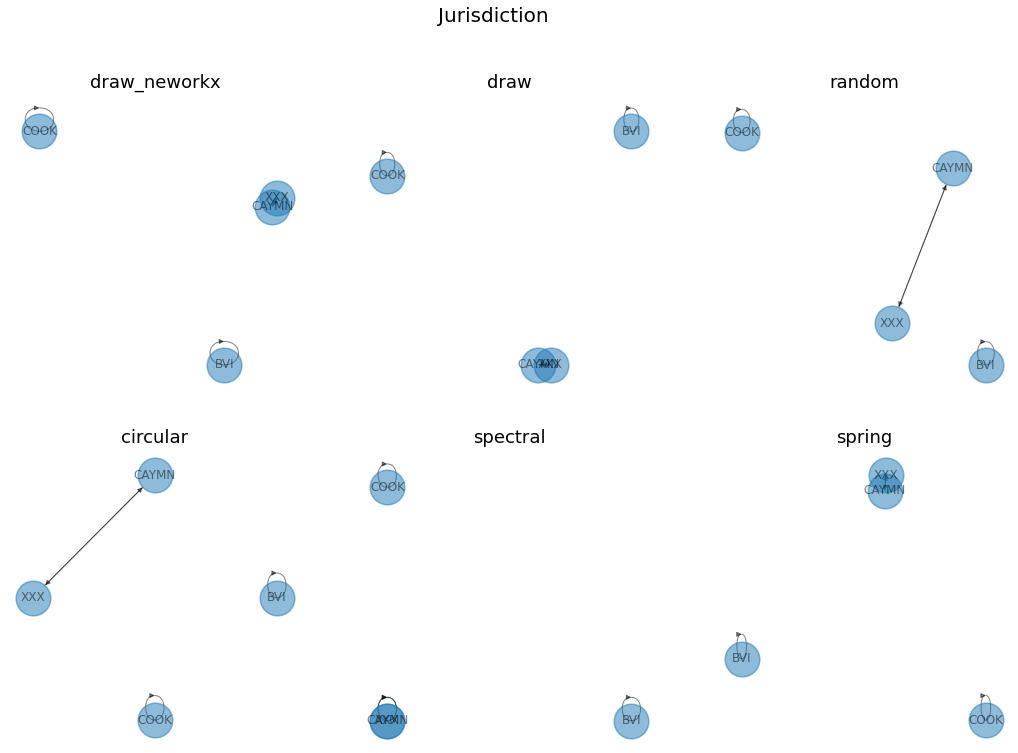

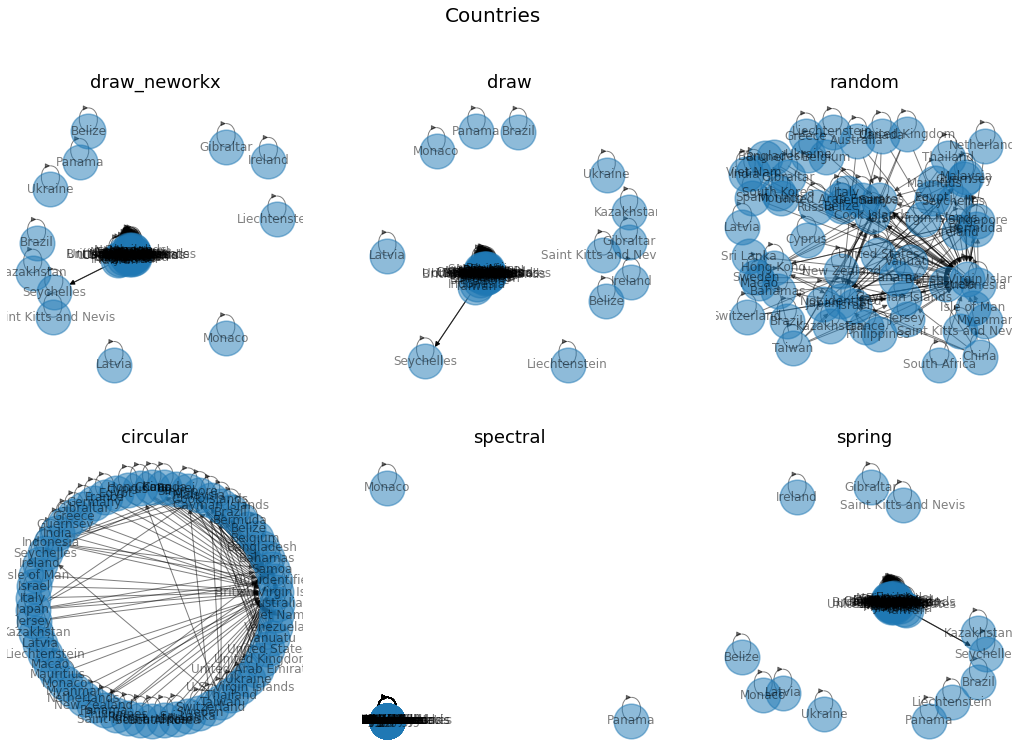

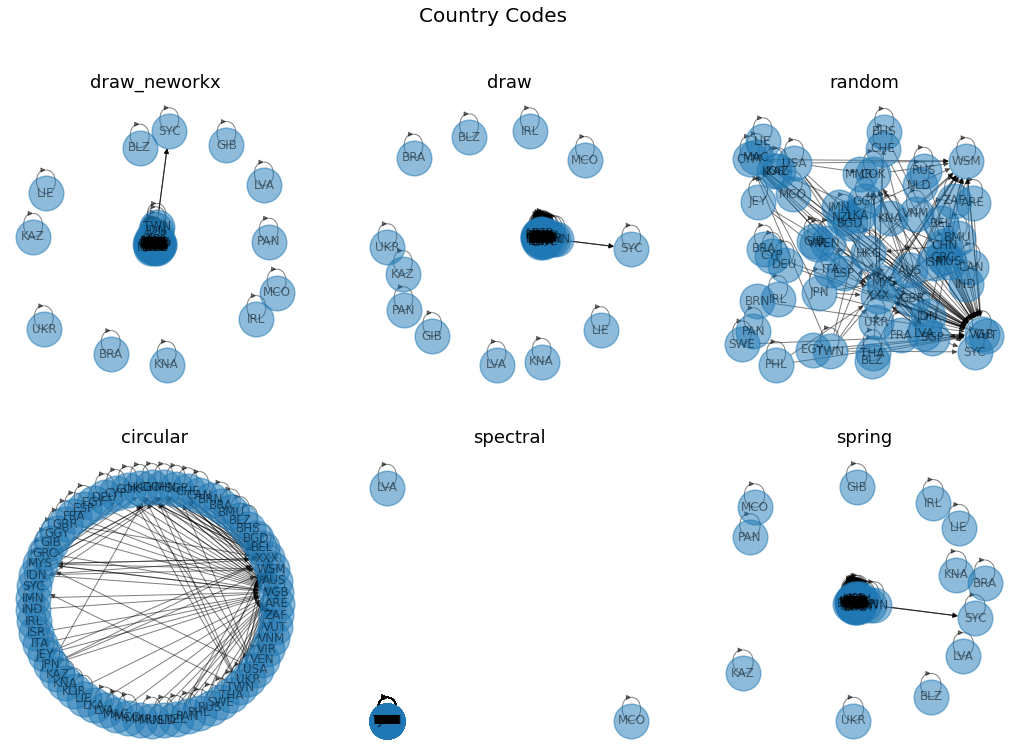

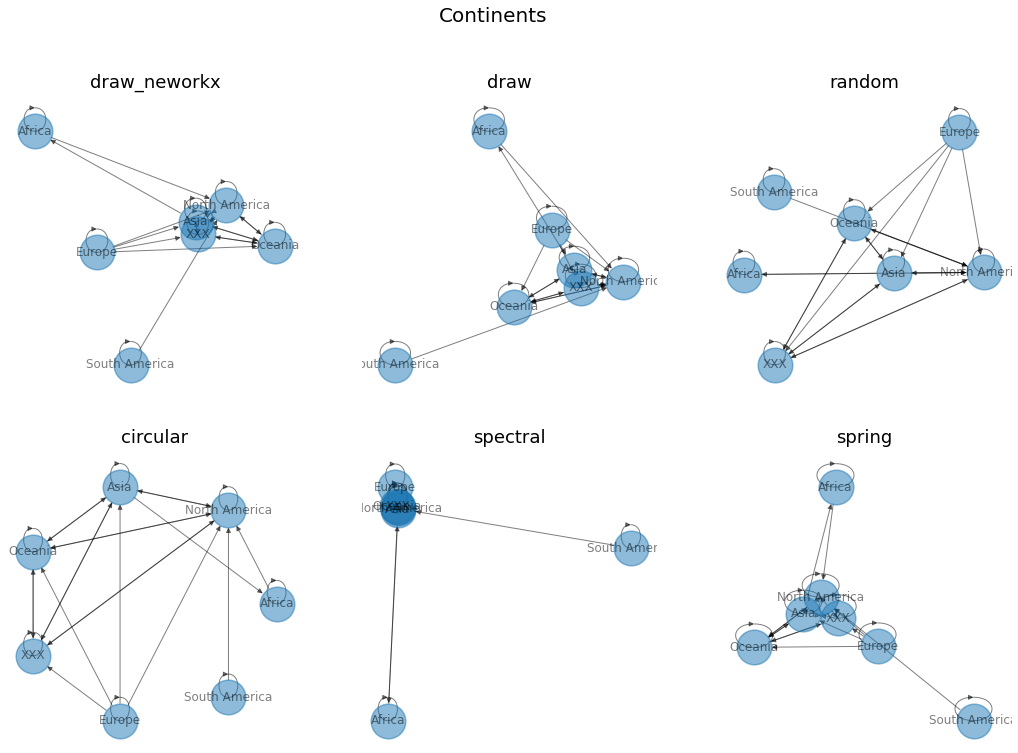

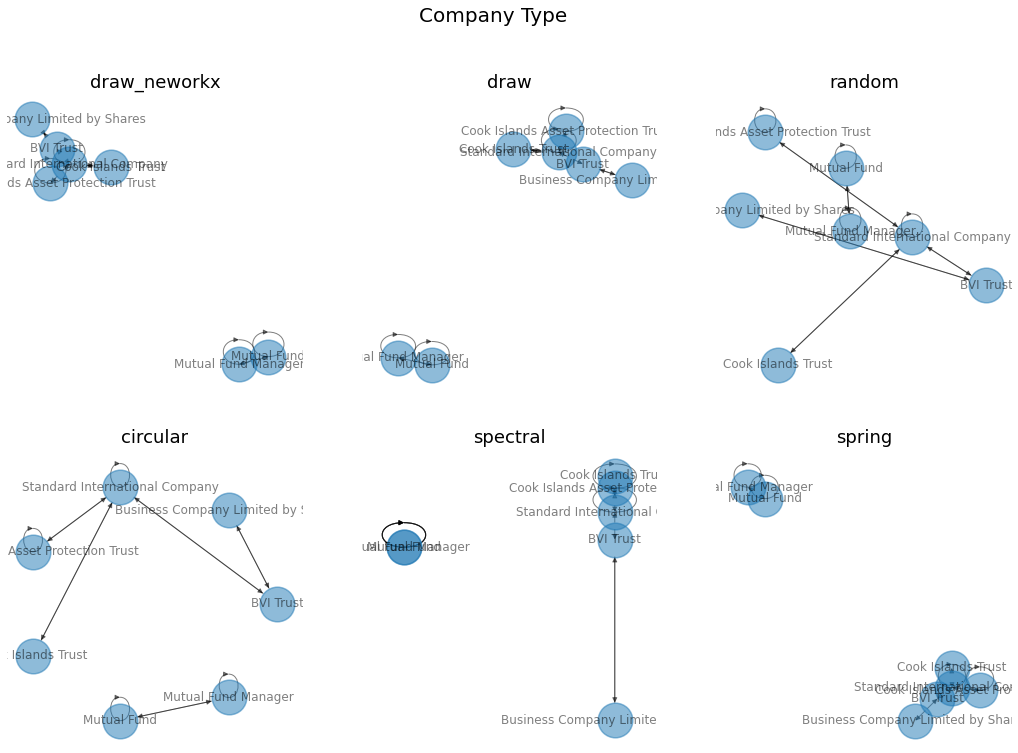

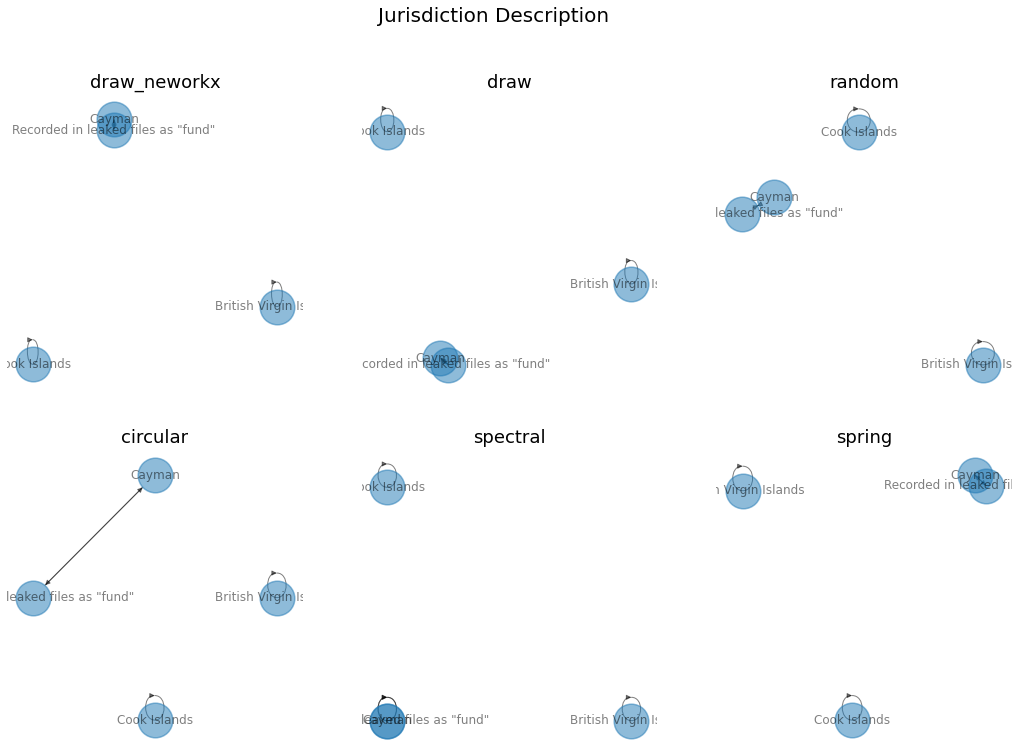

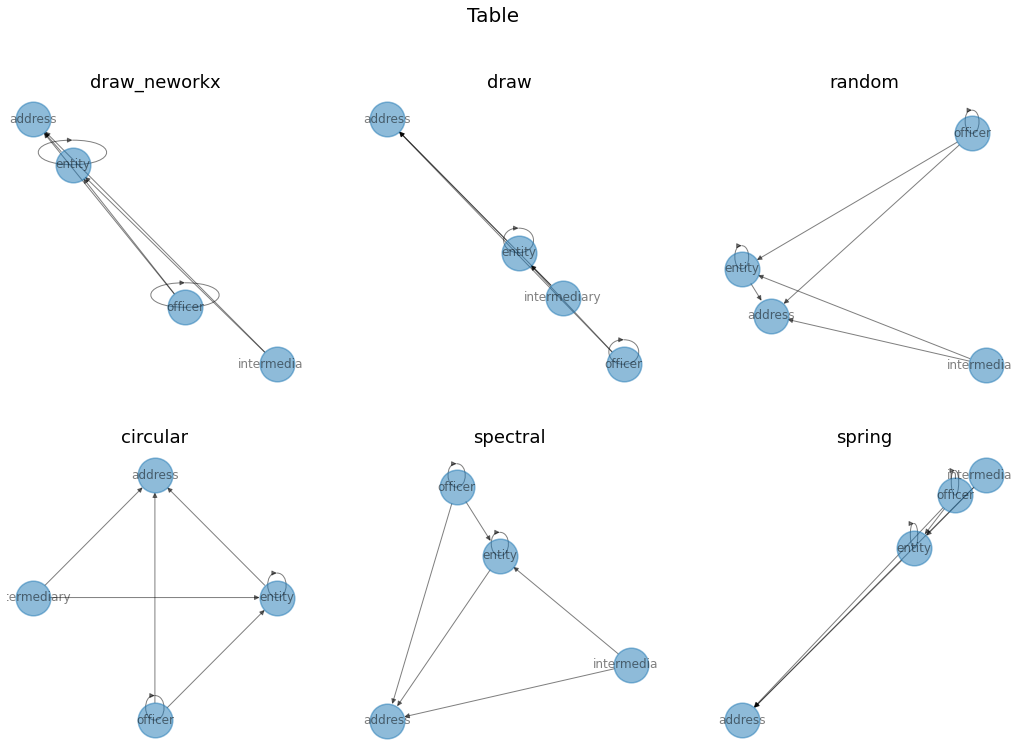

In [408]:
for field in ['jurisdiction', 'countries', 'country_codes', 'continents'] +  ['company_type', 'jurisdiction_description', 'table']:

  out.update({field: create_weight_df(edges_all, field, make_graph=True, select_thresh=True)})

In [ ]:
for field in ['jurisdiction', 'countries', 'country_codes', 'continents'] +  ['company_type', 'jurisdiction_description', 'table']:

  out.update({field: create_weight_df(edges_all, field, make_graph=True)})

In [373]:
edges_all.nunique().sort_values()

state_source                            0
address_source                          0
service_provider_target                 2
service_provider_source                 2
table_source                            3
TYPE                                    4
table_target                            4
jurisdiction_source                    19
jurisdiction_description_source        20
status_source                          20
status_target                          21
jurisdiction_target                    27
jurisdiction_description_target        28
continents_target                      49
state_target                           52
company_type_source                    52
link                                   53
company_type_target                    55
continents_source                      68
latitude_source                       168
longitude_source                      168
longitude_target                      217
latitude_target                       217
country_codes_target              

In [390]:
DF = out['country_codes']['df'].copy()
print(DF.shape)
DF[DF['weight']>1].shape

(910, 3)


(744, 3)

In [398]:
DF['weight'].max()/1000

49.298